# Basic Tutorial: `GaussLineNoise`

Trey V. Wenger (c) July 2024

This notebook is nearly identical to the basic tutorial, except we implement a new model called `GaussLineNoise`. This model allows the spectral rms to be an inferred parameter. Such is a useful trick for complicated posterior distributions, such as when there are multiple, high signal-to-noise components.

In [1]:
# General imports
from IPython.display import SVG, display
    
import os
import pickle

import matplotlib.pyplot as plt
import arviz as az
import pandas as pd
import numpy as np
import pymc as pm

import bayes_spec
print("bayes_spec version:", bayes_spec.__version__)

# Notebook configuration
pd.options.display.max_rows = None

# plot directory and extension
figdir = "figures"
ext = "svg"
if not os.path.isdir(figdir):
    os.mkdir(figdir)
    
# random state
rng = np.random.RandomState(seed=1234)

bayes_spec version: 1.2.0


## Data Format

We wish to generate some synthetic data from our model, which requires us to take a brief aside to introduce the `bayes_spec` data format. We use the `SpecData` class to pass data into `bayes_spec`.

In [2]:
from bayes_spec import SpecData

# spectral axis definition
velocity_axis = np.linspace(-250.0, 250.0, 501) # km/s

# brightness data. In this case, we just throw in some random data for now
# since we are only doing this in order to simulate some actual data.
brightness_data = np.random.randn(len(velocity_axis)) # K

# data noise can either be a scalar (assumed constant noise across the spectrum)
# or an array of the same length as the data
noise = 1.0 # K

# Our model only expects a single observation named "observation"
# Note that because we "named" the spectrum "observation" here,
# we must use the same name in the model definition above
observation = SpecData(
    velocity_axis,
    brightness_data,
    noise,
    xlabel=r"Velocity (km s$^{-1}$)",
    ylabel="Brightness Temperature (K)",
)
dummy_data = {"observation": observation}

## Simulating Data

Now that we have a model definition and a dummy data format, we can generate simulated observations by drawing samples from the parameter prior distributions.

Sampling: [fwhm_norm, line_area_norm, observation, observation_baseline_norm, rms_observation_norm, velocity_norm]


Text(0, 0.5, 'Brightness Temperature (K)')

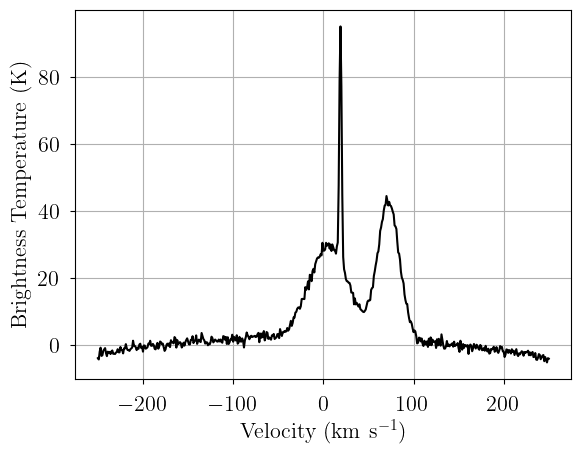

In [3]:
from bayes_spec.models import GaussLineNoise

# Initialize and define the model
model = GaussLineNoise(dummy_data, n_clouds=3, baseline_degree=2, seed=1234, verbose=True)
model.define(
    prior_line_area = 500.0, # mode of k=2 gamma distribution prior on line area (K km s-1)
    prior_fwhm = 25.0, # mode of k=2 gamma distribution prior on FWHM line width (km s-1)
    prior_velocity = [0.0, 50.0], # mean and width of normal distribution prior on centroid velocity (km s-1)
    prior_baseline_coeff = 1.0, # width of normal distribution prior on normalized baseline coefficients
    prior_rms = 1.0, # width of half-normal distribution prior on spectral rms (K)
)

# Draw one posterior predictive sample
simulated = model.prior_predictive_check(
    samples=1,
)
sim_brightness = simulated.prior_predictive["observation"].sel(chain=0, draw=0).data

# Plot the simulated data
plt.plot(dummy_data["observation"].spectral, sim_brightness, 'k-')
plt.xlabel(dummy_data["observation"].xlabel)
plt.ylabel(dummy_data["observation"].ylabel)

Alternatively, we can pass the relevant parameters directly to the likelihood variable, named `observation` in our model, to evaluate a model with specific model parameters. Be sure that the simulated values are reasonable given your prior distributions!

Text(0, 0.5, 'Brightness Temperature (K)')

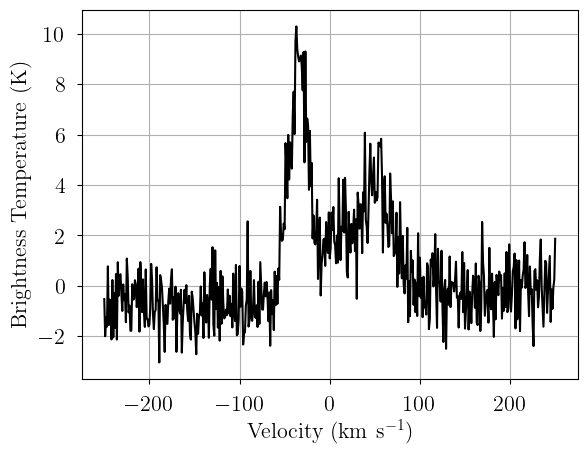

In [4]:
sim_brightness = model.model.observation.eval({
    "fwhm": [25.0, 40.0, 35.0], # FWHM line width (km/s)
    "line_area": [250.0, 125.0, 175.0], # line area (K km/s)
    "velocity": [-35.0, 10.0, 55.0], # velocity (km/s)
    "rms_observation": 1.0, # spectral rms (K)
    "observation_baseline_norm": [-0.5, 0.2, 0.05], # normalized baseline coefficients
})

# Plot the simulated data
plt.plot(dummy_data["observation"].spectral, sim_brightness, 'k-')
plt.xlabel(dummy_data["observation"].xlabel)
plt.ylabel(dummy_data["observation"].ylabel)

In [5]:
# Now we pack the simulated spectrum into a new SpecData instance
observation = SpecData(
    velocity_axis,
    sim_brightness,
    noise,
    xlabel=r"Velocity (km s$^{-1}$)",
    ylabel="Brightness Temperature (K)",
)
data = {"observation": observation}

## Model

Finally, with our model definition and (simulated) data in hand, we can explore the capabilities of `bayes_spec`.

We begin with a three-cloud (`n_cloud=3`) model, with a 2nd order polynomial baseline (`baseline_degree=2`).

In [6]:
model = GaussLineNoise(data, n_clouds=3, baseline_degree=2, seed=123456, verbose=True)
model.define(
    prior_line_area = 200.0, # mode of k=2 gamma distribution prior on line area (K km s-1)
    prior_fwhm = 30.0, # mode of k=2 gamma distribution prior on FWHM line width (km s-1)
    prior_velocity = [0.0, 50.0], # mean and width of normal distribution prior on centroid velocity (km s-1)
    prior_baseline_coeff = 1.0, # width of normal distribution prior on normalized baseline coefficients
    prior_rms = 2.0, # width of half-normal distribution prior on spectral rms (K)
)

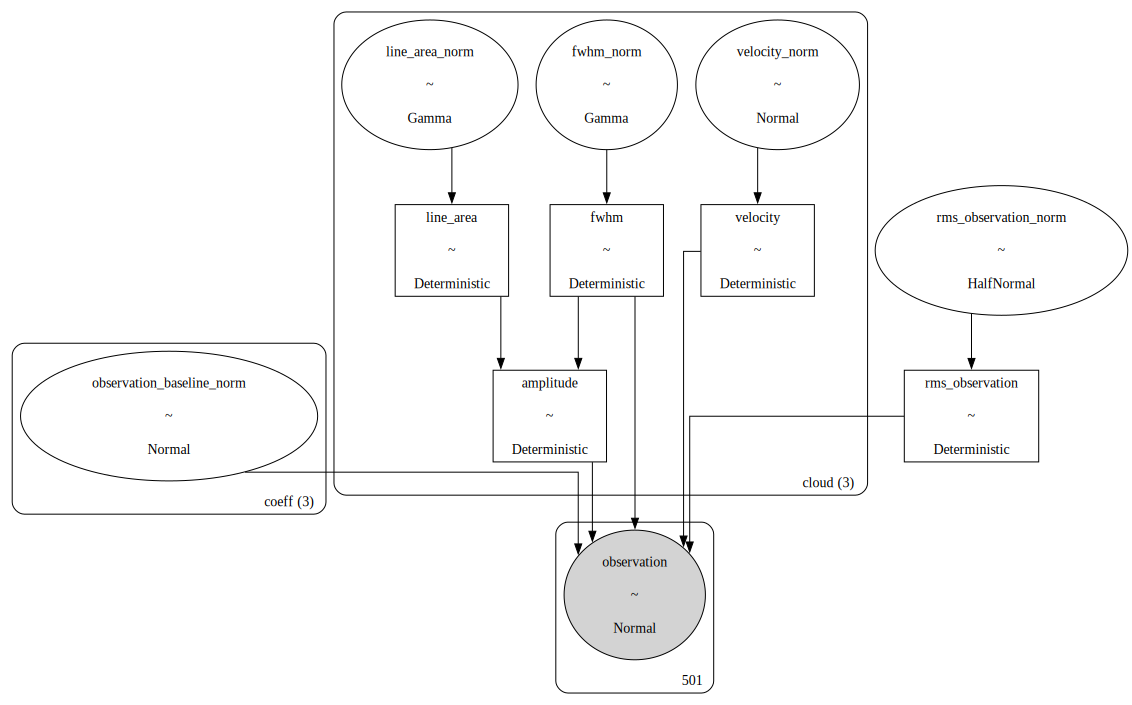

In [7]:
# Plot model graph
model.plot_graph(f"{figdir}/model.gv", "svg")
SVG(f"{figdir}/model.gv.{ext}")

In [8]:
# model string representation
print(model.model.str_repr())

observation_baseline_norm ~ Normal(0, 1)
           line_area_norm ~ Gamma(2, f())
                fwhm_norm ~ Gamma(2, f())
            velocity_norm ~ Normal(0, 1)
     rms_observation_norm ~ HalfNormal(0, 1)
                line_area ~ Deterministic(f(line_area_norm))
                     fwhm ~ Deterministic(f(fwhm_norm))
                 velocity ~ Deterministic(f(velocity_norm))
                amplitude ~ Deterministic(f(fwhm_norm, line_area_norm))
          rms_observation ~ Deterministic(f(rms_observation_norm))
              observation ~ Normal(f(fwhm_norm, line_area_norm, observation_baseline_norm, velocity_norm), rms_observation)


We check that our prior distributions are reasonable by drawing prior predictive checks. Each colored line is a simulated "observation" with parameters drawn from the prior distributions. You should check that these simulated observations at least somewhat overlap your actual observation (black line).

Sampling: [fwhm_norm, line_area_norm, observation, observation_baseline_norm, rms_observation_norm, velocity_norm]


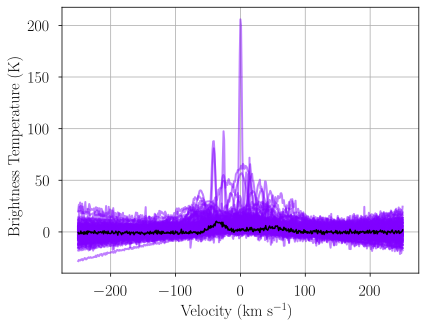

In [9]:
# prior predictive check
prior = model.prior_predictive_check(
    samples=100,  # prior predictive samples
    plot_fname=f"{figdir}/prior_predictive.{ext}",
)
SVG(f"{figdir}/prior_predictive.{ext}")

We can also generate a pair plot to inspect the prior distributions and their effect on deterministic quantities. The model has attributes `cloud_params` for cloud free parameters, `deterministics` for deterministic quantities, `baseline_params` for the free polynomial baseline parameters, and `hyper_params` for the hyperparameters. Here we show the pair plot for the deterministic quantities derived from our prior distributions.

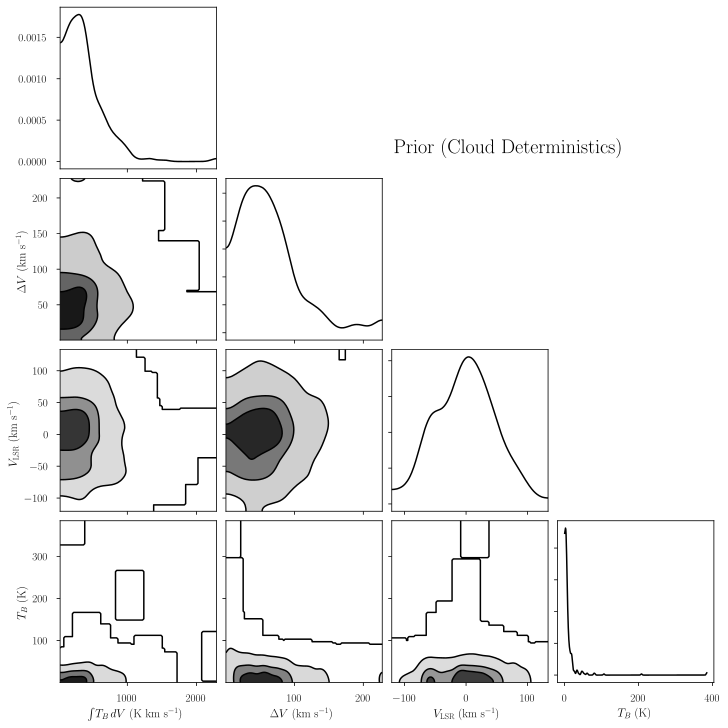

In [10]:
from bayes_spec.plots import plot_pair

# exclude rms_observation
var_names = [var_name for var_name in model.deterministics if var_name != "rms_observation"]
plot_pair(
    prior.prior, # samples
    var_names, # var_names to plot
    "Prior (Cloud Deterministics)", # plot label
    f"{figdir}/pair_prior_determ.{ext}", # plot filename
    labeller=model.labeller, # label manager
)
SVG(f"{figdir}/pair_prior_determ.{ext}")

## Posterior Sampling: Variational Inference

We can approximate the posterior distribution using variational inference (VI). We will run a maximum of `n` iterations, but stop early if it appears that VI has converged on a solution. You will have to tune the convergence thresholds and learning rate for your model.

In [11]:
model.fit(
    n = 500_000, # maximum number of VI iterations
    draws = 1_000, # number of posterior samples
    rel_tolerance = 0.01, # VI relative convergence threshold
    abs_tolerance = 0.01, # VI absolute convergence threshold
    learning_rate = 1e-3, # VI learning rate
)

Output()

Convergence achieved at 27000
Interrupted at 26,999 [5%]: Average Loss = 1,252


In [12]:
# posterior samples stored in model.trace.posterior
az.summary(model.trace.posterior)

arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)


mean      sd   hdi_3%  hdi_97%  mcse_mean  \
amplitude[0]                    8.721   0.488    7.840    9.661      0.018   
amplitude[1]                    2.403   0.283    1.905    2.951      0.009   
amplitude[2]                    3.325   0.411    2.601    4.102      0.013   
fwhm[0]                        24.080   1.037   22.134   25.982      0.035   
fwhm[1]                        83.429   7.661   70.003   97.667      0.247   
fwhm[2]                        38.591   3.694   31.698   45.416      0.134   
fwhm_norm[0]                    0.803   0.035    0.738    0.866      0.001   
fwhm_norm[1]                    2.781   0.255    2.333    3.256      0.008   
fwhm_norm[2]                    1.286   0.123    1.057    1.514      0.004   
line_area[0]                  223.118   7.718  210.788  239.264      0.264   
line_area[1]                  211.628  16.004  181.635  241.007      0.526   
line_area[2]                  135.304  10.278  113.790  152.264      0.327   
line_area_norm[0]               1.116   0.039    1.054    1.196      0.001   
line_area_norm[1]               1.058   0.080    0.908    1.205      0.003   
line_area_norm[2]               0.677   0.051    0.569    0.761      0.002   
observation_baseline_norm[0]   -0.547   0.025   -0.595   -0.499      0.001   
observation_baseline_norm[1]    0.104   0.022    0.065    0.147      0.001   
observation_baseline_norm[2]    0.045   0.019    0.010    0.079      0.001   
rms_observation                 1.049   0.038    0.985    1.123      0.001   
rms_observation_norm            0.524   0.019    0.493    0.562      0.001   
velocity[0]                   -35.048   0.563  -36.107  -33.991      0.017   
velocity[1]                    14.028   2.289    9.711   18.293      0.074   
velocity[2]                    54.490   3.257   48.543   60.578      0.104   
velocity_norm[0]               -0.701   0.011   -0.722   -0.680      0.000   
velocity_norm[1]                0.281   0.046    0.194    0.366      0.001   
velocity_norm[2]                1.090   0.065    0.971    1.212      0.002   

                              mcse_sd  ess_bulk  ess_tail  r_hat  
amplitude[0]                    0.013     721.0     903.0    NaN  
amplitude[1]                    0.006     955.0     942.0    NaN  
amplitude[2]                    0.009     971.0     944.0    NaN  
fwhm[0]                         0.025     882.0     833.0    NaN  
fwhm[1]                         0.175     968.0     939.0    NaN  
fwhm[2]                         0.096     770.0     768.0    NaN  
fwhm_norm[0]                    0.001     882.0     833.0    NaN  
fwhm_norm[1]                    0.006     968.0     939.0    NaN  
fwhm_norm[2]                    0.003     770.0     768.0    NaN  
line_area[0]                    0.187     858.0     907.0    NaN  
line_area[1]                    0.372     931.0     751.0    NaN  
line_area[2]                    0.232     989.0    1013.0    NaN  
line_area_norm[0]               0.001     858.0     907.0    NaN  
line_area_norm[1]               0.002     931.0     751.0    NaN  
line_area_norm[2]               0.001     989.0    1013.0    NaN  
observation_baseline_norm[0]    0.001    1031.0     983.0    NaN  
observation_baseline_norm[1]    0.000    1013.0    1070.0    NaN  
observation_baseline_norm[2]    0.000    1054.0     790.0    NaN  
rms_observation                 0.001     944.0     982.0    NaN  
rms_observation_norm            0.000     944.0     982.0    NaN  
velocity[0]                     0.012    1054.0     936.0    NaN  
velocity[1]                     0.052     959.0     942.0    NaN  
velocity[2]                     0.074     971.0    1017.0    NaN  
velocity_norm[0]                0.000    1054.0     936.0    NaN  
velocity_norm[1]                0.001     959.0     942.0    NaN  
velocity_norm[2]                0.001     971.0    1017.0    NaN

It's good practice to verify the integrity of your solution! Here we generate posterior predictive checks -- realizations of the model drawn with parameters drawn from the posterior distribution. Each line is one posterior sample.

Sampling: [observation]


Output()

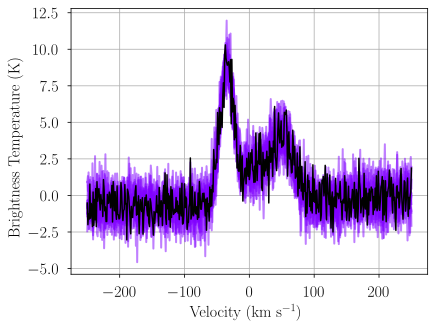

In [13]:
posterior_predictive = model.posterior_predictive_check(
    thin=100, plot_fname=f"{figdir}/posterior_predictive_vi.{ext}"
)
SVG(f"{figdir}/posterior_predictive_vi.{ext}")

## Posterior Sampling: MCMC

VI is fast, but it's not particularly accurate, and there is no way to diagnose "convergence". Instead, we sample the posterior distribution using MCMC. Here we initialize the No U-Turn Sampler (NUTS) using VI (also available is the `pymc` default: `init="jitter+adapt_diag"`, which may be better suited to some models). We can customize the VI initialization as well as the NUTS parameters. If there are many divergences, or if the resulting effective sample sizes are small and `r_hat` is large, try increasing the number of tuning samples, draws, and/or chains. Increasing `target_accept` to `0.9` or `0.95` can help if there are many divergences. Use as many chains as possible.

In [14]:
model.sample(
    init = "advi+adapt_diag", # initialization strategy
    tune = 1000, # tuning samples
    draws = 1000, # posterior samples
    chains = 4, # number of independent chains
    cores = 4, # number of parallel chains
    init_kwargs = {"rel_tolerance": 0.01, "abs_tolerance": 0.01, "learning_rate": 1e-3}, # VI initialization arguments
    nuts_kwargs = {"target_accept": 0.8}, # NUTS arguments
)

Initializing NUTS using custom advi+adapt_diag strategy


Output()

Convergence achieved at 27000
Interrupted at 26,999 [5%]: Average Loss = 1,252
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [observation_baseline_norm, line_area_norm, fwhm_norm, velocity_norm, rms_observation_norm]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 33 seconds.


There were 5 divergences in converged chains.


If a chain does not converge, an error is printed and that chain is dropped from all subsequent analyses. In the remaining chains, there may be some divergences. The number of divergences should be much less than the number of posterior samples.

In general, there could be a labeling degeneracy, or multiple unique solutions. Here we "solve" for those effects using a Gaussian Mixture Model (GMM). The parameter `p_threshold` defines the probability threshold for "unique" GMM solutions.

In [15]:
model.solve(p_threshold=0.9)

GMM converged to unique solution


In [16]:
print("solutions:", model.solutions)
display(az.summary(model.trace["solution_0"]))
# this also works: az.summary(model.trace.solution_0)

solutions: [0]


mean      sd   hdi_3%  hdi_97%  mcse_mean  \
amplitude[0]                    8.980   0.488    8.046    9.837      0.019   
amplitude[1]                    2.702   0.328    2.100    3.314      0.010   
amplitude[2]                    3.437   0.864    2.200    4.980      0.050   
fwhm[0]                        24.451   1.408   21.914   27.029      0.056   
fwhm[1]                        76.536  28.490   24.857  114.569      1.741   
fwhm[2]                        34.016   7.491   21.711   48.243      0.386   
fwhm_norm[0]                    0.815   0.047    0.730    0.901      0.002   
fwhm_norm[1]                    2.551   0.950    0.829    3.819      0.058   
fwhm_norm[2]                    1.134   0.250    0.724    1.608      0.013   
line_area[0]                  233.950  21.297  198.590  274.580      1.030   
line_area[1]                  223.128  93.138   66.531  357.831      5.649   
line_area[2]                  129.370  56.175   52.045  230.218      3.351   
line_area_norm[0]               1.170   0.106    0.993    1.373      0.005   
line_area_norm[1]               1.116   0.466    0.333    1.789      0.028   
line_area_norm[2]               0.647   0.281    0.260    1.151      0.017   
observation_baseline_norm[0]   -0.568   0.069   -0.702   -0.443      0.003   
observation_baseline_norm[1]    0.100   0.021    0.059    0.138      0.000   
observation_baseline_norm[2]    0.058   0.038   -0.012    0.131      0.001   
rms_observation                 1.032   0.033    0.971    1.095      0.001   
rms_observation_norm            0.516   0.017    0.485    0.547      0.000   
velocity[0]                   -34.797   0.479  -35.661  -33.877      0.014   
velocity[1]                    17.186   9.163    2.467   32.928      0.483   
velocity[2]                    53.889   2.000   50.004   57.526      0.059   
velocity_norm[0]               -0.696   0.010   -0.713   -0.678      0.000   
velocity_norm[1]                0.344   0.183    0.049    0.659      0.010   
velocity_norm[2]                1.078   0.040    1.000    1.151      0.001   

                              mcse_sd  ess_bulk  ess_tail  r_hat  
amplitude[0]                    0.013     709.0    1686.0   1.00  
amplitude[1]                    0.007    1027.0    2000.0   1.00  
amplitude[2]                    0.036     365.0    1567.0   1.01  
fwhm[0]                         0.040     634.0    1351.0   1.01  
fwhm[1]                         1.232     316.0    1329.0   1.01  
fwhm[2]                         0.274     396.0    1392.0   1.00  
fwhm_norm[0]                    0.001     634.0    1351.0   1.01  
fwhm_norm[1]                    0.041     316.0    1329.0   1.01  
fwhm_norm[2]                    0.009     396.0    1392.0   1.00  
line_area[0]                    0.739     452.0     990.0   1.01  
line_area[1]                    3.999     305.0    1173.0   1.01  
line_area[2]                    2.372     338.0    1315.0   1.01  
line_area_norm[0]               0.004     452.0     990.0   1.01  
line_area_norm[1]               0.020     305.0    1173.0   1.01  
line_area_norm[2]               0.012     338.0    1315.0   1.01  
observation_baseline_norm[0]    0.002     737.0    1059.0   1.00  
observation_baseline_norm[1]    0.000    2366.0    2519.0   1.00  
observation_baseline_norm[2]    0.001     844.0    1340.0   1.00  
rms_observation                 0.000    2283.0    1969.0   1.00  
rms_observation_norm            0.000    2283.0    1969.0   1.00  
velocity[0]                     0.010    1208.0    1648.0   1.00  
velocity[1]                     0.342     402.0    1456.0   1.00  
velocity[2]                     0.042    1175.0    2132.0   1.00  
velocity_norm[0]                0.000    1208.0    1648.0   1.00  
velocity_norm[1]                0.007     402.0    1456.0   1.00  
velocity_norm[2]                0.001    1175.0    2132.0   1.00

We again generate posterior predictive checks as well as a trace plot of the individual chains. In the posterior predictive plot, we show each chain as a different color, and the "thin" lines are the contributions of individual clouds. Each line is one posterior sample.

Sampling: [observation]


Output()

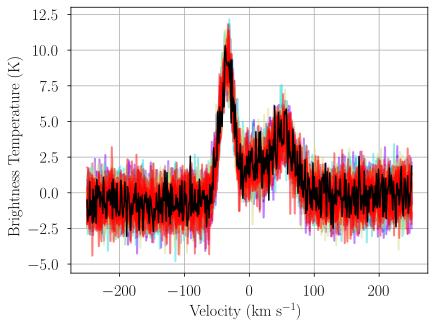

In [17]:
posterior_predictive = model.posterior_predictive_check(
    thin=100, plot_fname=f"{figdir}/posterior_predictive.{ext}"
)
SVG(f"{figdir}/posterior_predictive.{ext}")

In [18]:
model.plot_traces(f"{figdir}/traces.{ext}")
SVG(f"{figdir}/traces.{ext}")

We can inspect the posterior distribution pair plots. First, the (deterministic) cloud parameters.

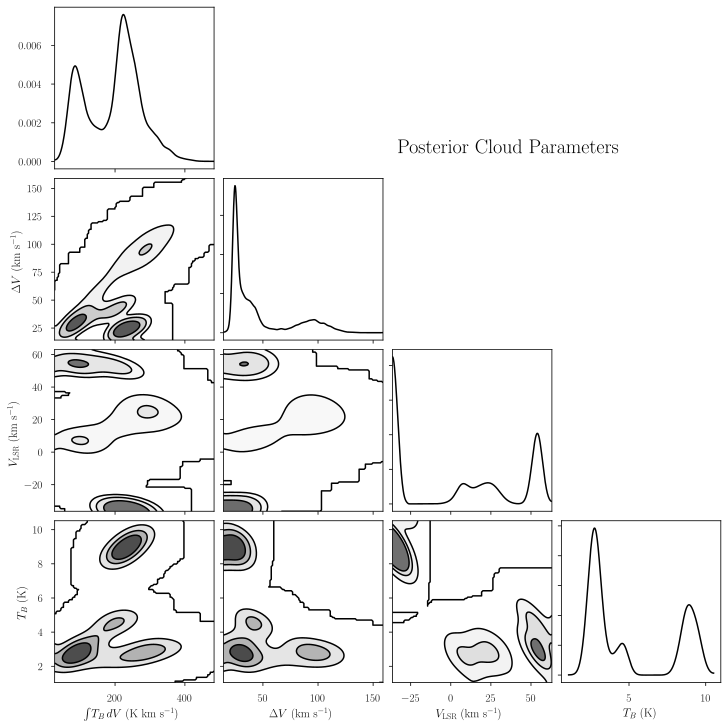

In [19]:
var_names = [var_name for var_name in model.deterministics if var_name != "rms_observation"]
plot_pair(
    model.trace.solution_0, # samples
    var_names, # var_names to plot
    "Posterior Cloud Parameters", # plot label
    f"{figdir}/pair_posterior_cloud_params.{ext}", # plot filename
    labeller=model.labeller, # label manager
)
SVG(f"{figdir}/pair_posterior_cloud_params.{ext}")

Notice that there are three posterior modes. These correspond to the three clouds of the model. We can plot the posterior distributions for a single cloud.

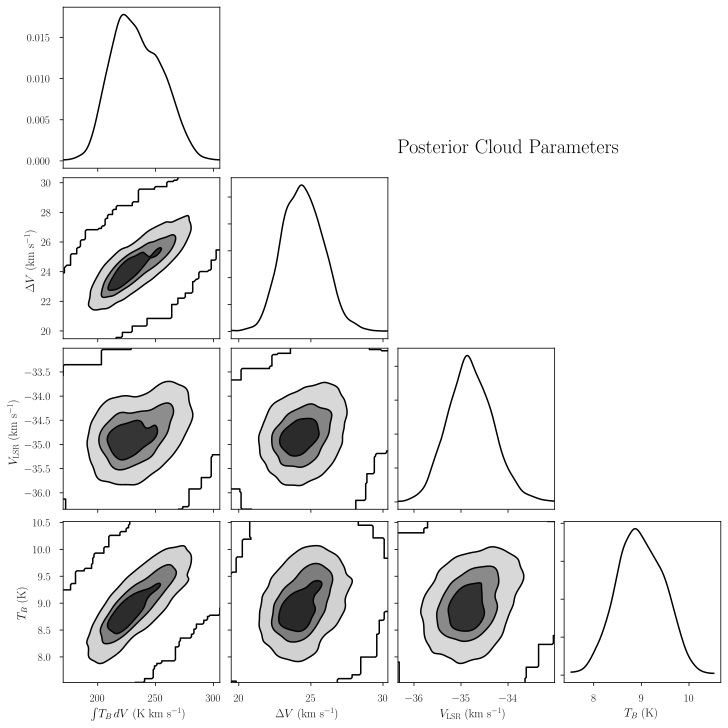

In [20]:
var_names = [var_name for var_name in model.deterministics if var_name != "rms_observation"]
plot_pair(
    model.trace.solution_0.sel(cloud=0), # samples
    var_names, # var_names to plot
    "Posterior Cloud Parameters", # plot label
    f"{figdir}/pair_posterior_cloud_params_0.{ext}", # plot filename
    labeller=model.labeller, # label manager
)
SVG(f"{figdir}/pair_posterior_cloud_params_0.{ext}")

Finally, we can get the posterior statistics, Bayesian Information Criterion (BIC), etc.

In [21]:
point_stats = az.summary(model.trace.solution_0, var_names=model.deterministics, kind='stats', hdi_prob=0.68)
print("BIC:", model.bic())
display(point_stats)

BIC: 1556.2529239634682


mean      sd  hdi_16%  hdi_84%
line_area[0]     233.950  21.297  208.964  253.128
line_area[1]     223.128  93.138  117.653  329.525
line_area[2]     129.370  56.175   54.641  167.526
fwhm[0]           24.451   1.408   22.855   25.644
fwhm[1]           76.536  28.490   55.022  115.601
fwhm[2]           34.016   7.491   24.331   39.844
velocity[0]      -34.797   0.479  -35.304  -34.363
velocity[1]       17.186   9.163    5.723   25.623
velocity[2]       53.889   2.000   52.165   56.041
amplitude[0]       8.980   0.488    8.494    9.492
amplitude[1]       2.702   0.328    2.400    3.050
amplitude[2]       3.437   0.864    2.333    4.248
rms_observation    1.032   0.033    0.994    1.060